In [2]:
import os
import subprocess
import glob
import subprocess
from pathlib import Path

# Define paths
root_data = Path("/mnt/data")
project_dir  = os.path.join(root_data, "gmtsar_test_2")
data_dir = os.path.join(project_dir, "data")
reframed_dir = os.path.join(project_dir, "reframed")
pins_ll = os.path.join(reframed_dir, "pins.ll")
safe_list_path = os.path.join(data_dir, "SAFE_filelist.txt")
download_dir = data_dir
dem_dir = os.path.join(project_dir, "topo")
orbit_dir = os.path.join(project_dir, "orbit")
# Orbit files go under raw

os.makedirs(download_dir, exist_ok=True)
os.makedirs(dem_dir, exist_ok=True)

print(f"DEM directory: {dem_dir}")
print(f"RAW SLC directory: {download_dir}")
print(f"Orbit directory: {orbit_dir}")





DEM directory: /mnt/data/gmtsar_test_2/topo
RAW SLC directory: /mnt/data/gmtsar_test_2/data
Orbit directory: /mnt/data/gmtsar_test_2/orbit


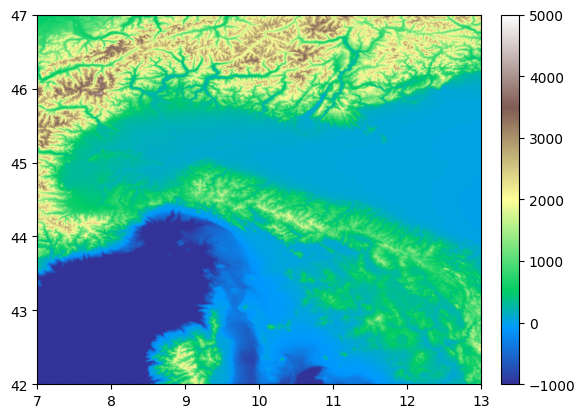

In [4]:
# Check on the dem plot
import os
from netCDF4 import Dataset as NetCDFFile 
import matplotlib.pyplot as plt
import numpy as np

dem_path = os.path.join(project_dir, "topo", "dem.grd")

nc = NetCDFFile(dem_path)
x = nc.variables['lon'][:]
y = nc.variables['lat'][:]
z = nc.variables['z'][:]
# make the necessary flip for plotting
z = np.flip(z, axis=0)
b = plt.imshow(z, extent=[np.min(x), np.max(x), np.min(y), np.max(y)], cmap='terrain',aspect=1,vmin = -1000, vmax = 5000)
plt.rcParams["figure.figsize"] = [10,10]
bar2 = plt.colorbar(b,fraction=0.046, pad=0.04)


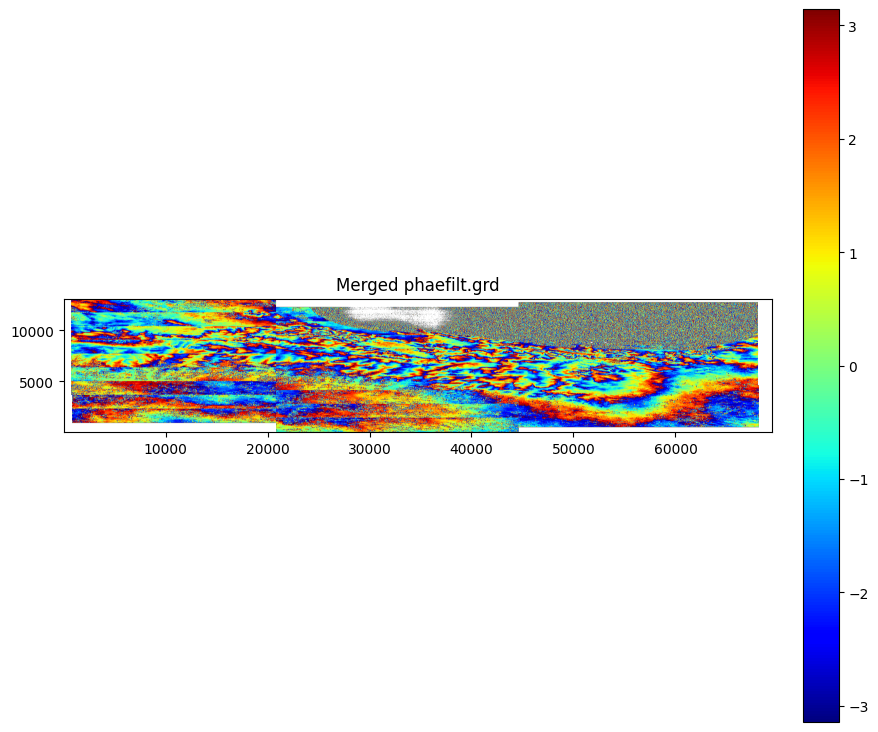

In [8]:
# Check on the dem plot
import os
from netCDF4 import Dataset as NetCDFFile 
import matplotlib.pyplot as plt
import numpy as np

# Plot the merged phaefilt.grd file
merge_grd_path = "/mnt/data/gmtsar_test_2/merge/2023086_2023110/phasefilt.grd"
nc_merge = NetCDFFile(merge_grd_path)
x_merge = nc_merge.variables['x'][:]
y_merge = nc_merge.variables['y'][:]
z_merge = nc_merge.variables['z'][:]
z_merge = np.flip(z_merge, axis=0)

plt.figure(figsize=(10, 10))
im = plt.imshow(z_merge, extent=[np.min(x_merge), np.max(x_merge), np.min(y_merge), np.max(y_merge)], cmap='jet', aspect=1)
plt.title("Merged phaefilt.grd")
bar = plt.colorbar(im, fraction=0.046, pad=0.04)
plt.show()

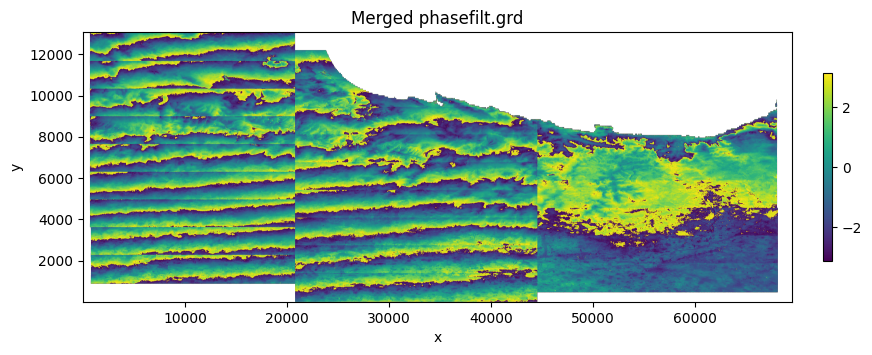

In [3]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import os, math

p = "/mnt/data/gmtsar_test_2/merge/2024021_2024033/phasefilt.grd"
assert os.path.exists(p), f"not found: {p}"

nc_merge = Dataset(p)
x = nc_merge.variables["x"][:]           # (nx,)
y = nc_merge.variables["y"][:]           # (ny,)
z = nc_merge.variables["z"][:]           # (ny, nx)
nc_merge.close()

fig, ax = plt.subplots(figsize=(10, 3.5))   # shorter figure → smaller colorbar
extent = [x.min(), x.max(), y.min(), y.max()]
im = ax.imshow(z, extent=extent, origin="lower", aspect="auto",
               vmin=-math.pi, vmax=math.pi)   # phase range [-π, π]
ax.set_title("Merged phasefilt.grd")
ax.set_xlabel("x"); ax.set_ylabel("y")
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, shrink=0.7)
plt.show()


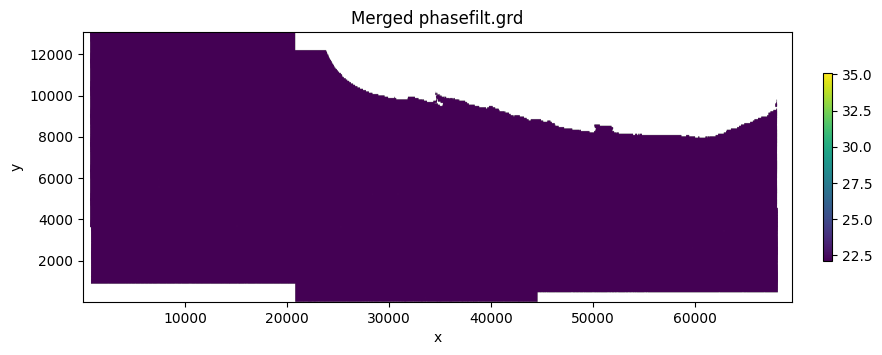

In [ ]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import os, math

p = "/mnt/data/gmtsar_test_2/merge/2023086_2023110/unwrap.grd"
assert os.path.exists(p), f"not found: {p}"

nc_merge = Dataset(p)
x = nc_merge.variables["x"][:]           # (nx,)
y = nc_merge.variables["y"][:]           # (ny,)
z = nc_merge.variables["z"][:]           # (ny, nx)
nc_merge.close()
vmin, vmax = float(np.nanmin(z)), float(np.nanmax(z))

print (vmin, vmax)
fig, ax = plt.subplots(figsize=(10, 3.5))   # shorter figure → smaller colorbar
extent = [x.min(), x.max(), y.min(), y.max()]
im = ax.imshow(z, extent=extent, origin="lower", aspect="auto",
               vmin=-vmin, vmax=vmax)   # phase range [-π, π]
ax.set_title("Merged phasefilt.grd")
ax.set_xlabel("x"); ax.set_ylabel("y")
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, shrink=0.7)
plt.show()

In [ ]:
import xarray as xr

ds = xr.open_dataset("yourfile.nc")
print(ds)                  # dataset summary
print(ds.data_vars)        # variable names
print(ds.coords)           # coordinates
print(ds.attrs)            # metadata

# Inspect one variable
varname = list(ds.data_vars.keys())[0]
print(ds[varname])

# Get min/max for plotting
vmin = float(ds[varname].min())
vmax = float(ds[varname].max())
print(vmin, vmax)


/home/ubuntu/anaconda3/envs/insar/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4859: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


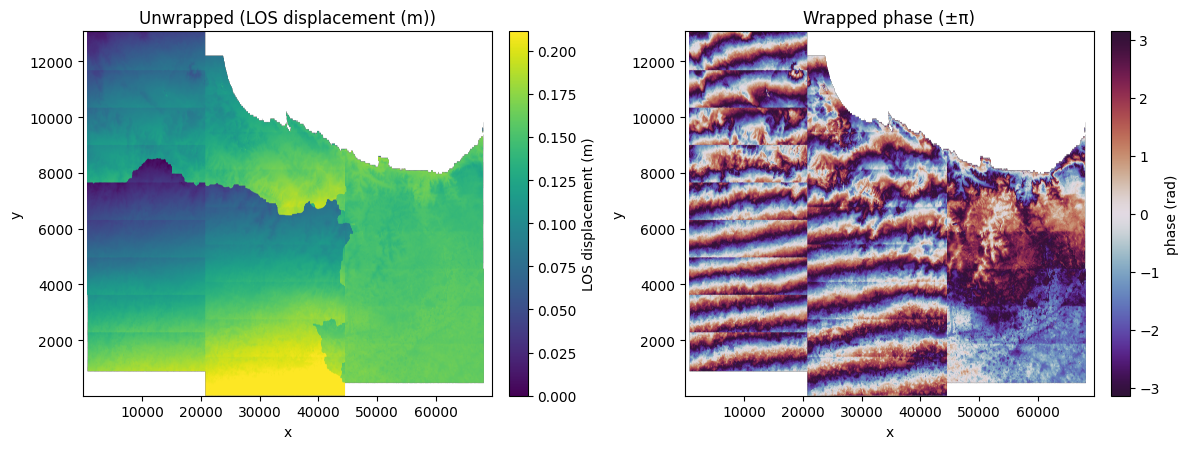

In [1]:
# --- deps
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

# ----------------- helpers -----------------
def read_grid_nc(path):
    """Return x, y, z from a GMT/NetCDF grid (unwrap.grd / phasefilt.grd)."""
    with Dataset(path) as ds:
        x = ds.variables["x"][:]
        y = ds.variables["y"][:]
        z = ds.variables["z"][:]  # unwrapped phase [radians]
    return x, y, z

def robust_norm(data, center_zero=False, lo=2, hi=98):
    """Percentile-based normalization, with optional zero-centering."""
    v = data[np.isfinite(data)]
    if v.size == 0:
        return mcolors.Normalize(vmin=0, vmax=1)
    p_lo, p_hi = np.percentile(v, [lo, hi])
    if center_zero:
        vmin = min(0.0, p_lo)
        vmax = max(0.0, p_hi)
        return mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
    return mcolors.Normalize(vmin=p_lo, vmax=p_hi, clip=True)

def extent_from_coords(x, y):
    """imshow extent from 1D coords (assumes pixel registration)."""
    return [x.min(), x.max(), y.min(), y.max()]

# --------------- configuration ----------------
# Input unwrapped phase (radians)
grid_path = "/mnt/data/gmtsar_test_2/merge/2024021_2024033/unwrap.grd"

# Optional: external mask (True = keep, False = mask out). If you already built
# a mask elsewhere, pass it as a NumPy array with same shape as the grid.
external_mask = None           # e.g., np.load("my_mask.npy")  or None

# Optional: mask from coherence threshold (if you have corr.grd next to it)
use_coh_mask = False
coh_threshold = 0.075

# Unit to display: "phase_rad", "phase_cycles", or "los_m"
mode = "los_m"

# Radar wavelength (m) for LOS conversion
wavelength = 0.055465  # Sentinel-1 C-band

# --------------- load & prepare data ---------------
assert os.path.exists(grid_path), f"not found: {grid_path}"
x, y, z_rad = read_grid_nc(grid_path)          # radians (unwrapped)

# Build a mask: start from finite values
mask = np.isfinite(z_rad)
if external_mask is not None:
    mask &= external_mask.astype(bool)

if use_coh_mask:
    # try to read coherence grid sitting next to unwrap.grd
    coh_path = os.path.join(os.path.dirname(grid_path), "corr.grd")
    if os.path.exists(coh_path):
        _, _, corr = read_grid_nc(coh_path)
        mask &= np.isfinite(corr) & (corr >= coh_threshold)

# Create a masked array
z_rad_ma = np.ma.masked_where(~mask, z_rad)

# Convert units for plotting
if mode == "phase_rad":
    data = z_rad_ma
    label = "phase (rad)"
    cmap = "RdBu_r"
    norm = robust_norm(data, center_zero=True)
elif mode == "phase_cycles":
    data = z_rad_ma / (2*np.pi)
    label = "phase (cycles)"
    cmap = "PuOr_r"
    norm = robust_norm(data, center_zero=True)
elif mode == "los_m":
    data = (wavelength/(4*np.pi)) * z_rad_ma
    label = "LOS displacement (m)"
    cmap = "viridis"
    norm = robust_norm(data, center_zero=False)  # displacement not always symmetric
else:
    raise ValueError("mode must be 'phase_rad', 'phase_cycles', or 'los_m'")

# --------------- plot: displacement + wrapped for reference ---------------
fig = plt.figure(figsize=(12, 4.6))

# left: chosen unit
ax1 = fig.add_subplot(1, 2, 1)
im1 = ax1.imshow(data, extent=extent_from_coords(x, y),
                 origin="lower", aspect="auto", cmap=cmap, norm=norm)
ax1.set_title(f"Unwrapped ({label})")
ax1.set_xlabel("x"); ax1.set_ylabel("y")
cb1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
cb1.set_label(label)

# right: wrapped view (for intuition), using [-π, π] and diverging cmap
ax2 = fig.add_subplot(1, 2, 2)
wrapped = np.angle(np.exp(1j * z_rad_ma))  # wrap to (-π, π]
im2 = ax2.imshow(wrapped, extent=extent_from_coords(x, y),
                 origin="lower", aspect="auto",
                 cmap="twilight_shifted", vmin=-np.pi, vmax=np.pi)
ax2.set_title("Wrapped phase (±π)")
ax2.set_xlabel("x"); ax2.set_ylabel("y")
cb2 = fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
cb2.set_label("phase (rad)")

plt.tight_layout()
plt.show()


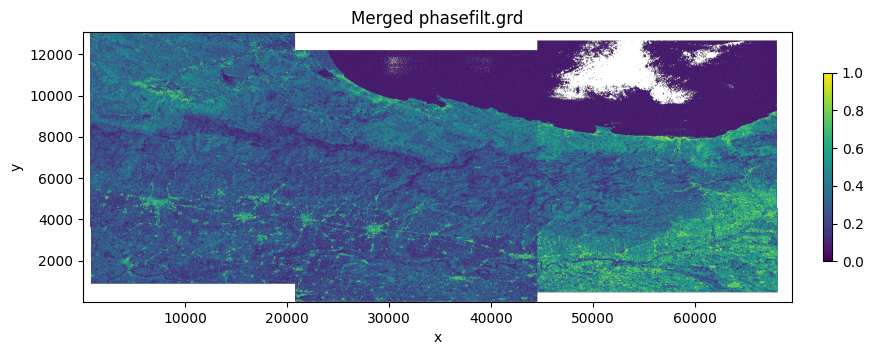

In [2]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import os, math

p = "/mnt/data/gmtsar_test_2/merge/2024021_2024033/corr.grd"
assert os.path.exists(p), f"not found: {p}"

nc_merge = Dataset(p)
x = nc_merge.variables["x"][:]           # (nx,)
y = nc_merge.variables["y"][:]           # (ny,)
z = nc_merge.variables["z"][:]           # (ny, nx)
nc_merge.close()
#vmin, vmax = float(np.nanmin(z)), float(np.nanmax(z))

fig, ax = plt.subplots(figsize=(10, 3.5))   # shorter figure → smaller colorbar
extent = [x.min(), x.max(), y.min(), y.max()]
im = ax.imshow(z, extent=extent, origin="lower", aspect="auto",
               vmin=-0, vmax=1)   # range [-π, π]
ax.set_title("Merged phasefilt.grd")
ax.set_xlabel("x"); ax.set_ylabel("y")
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, shrink=0.7)
plt.show()

In [16]:
def extents(vector_component):
        delta = vector_component[1] - vector_component[0]
        return [vector_component[0] - delta/2, vector_component[-1] + delta/2]

In [18]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
def plot_model(infile, line, sample, posting, output_filename=None, dpi=72):
    # Calculate the bounding box
    extent_xvec = extents((np.arange(1, sample*posting, posting)) / 1000)
    extent_yvec = extents((np.arange(1, line*posting, posting)) / 1000)
    extent_xy = extent_xvec + extent_yvec
    
    plt.rcParams.update({'font.size': 14})
    inwrapped = (infile/10 + np.pi) % (2*np.pi) - np.pi
    cmap = copy.copy(plt.colormaps["jet"])
    cmap.set_bad('white', 1.)
    
    # Plot displacement
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(1, 2, 1)
    im = ax1.imshow(infile, interpolation='nearest', cmap=cmap, extent=extent_xy, origin='upper')
    cbar = ax1.figure.colorbar(im, ax=ax1, orientation='horizontal')
    ax1.set_title("Displacement in look direction [mm]")
    ax1.set_xlabel("Easting [km]")
    ax1.set_ylabel("Northing [km]")
    plt.grid()
    
    # Plot interferogram
    im.set_clim(-30, 30)
    ax2 = fig.add_subplot(1, 2, 2)
    im = ax2.imshow(inwrapped, interpolation='nearest', cmap=cmap, extent=extent_xy, origin='upper')
    cbar = ax2.figure.colorbar(im, ax=ax2, orientation='horizontal')
    ax2.set_title("Interferogram phase [rad]")
    ax2.set_xlabel("Easting [km]")
    ax2.set_ylabel("Northing [km]")
    plt.grid()
    
    if output_filename:
        plt.savefig(output_filename, dpi=dpi)